## WaveNet training

Here we train WaveNet to classify the MIT-BIH dataset, using hyperparameters drawn from `wavenet_hyperopt`.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

import tools.train as train
import tools.models as models
import tools.plot as plot

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)

# Make the CNN
nblocks = 7
nfilters = 54
dilation_limit = inputs["train"].shape[1]

# Start
layerlist_res = [("conv", {"filters": nfilters, "width": 1, "padding": "causal"})]

# Residual blocks
models.add_res_blocks(nblocks, nfilters, dilation_limit, layerlist_res)

# End
layerlist_res.extend([
    (layers.Activation("relu"),),
    ("conv", {"filters": nfilters, "width": 1, "padding": "causal"}),
    ("conv", {"filters": 1, "width": 1, "padding": "causal"}),
    (layers.Dropout(0.32,),)
])

config = {"optimizer": "Nadam",
          "loss": "categorical_crossentropy",
          "batch_size": 82,
          "val_split": 0.05,
          "epochs": 300,
          "verbose": 0,
          "patience": 20,
          "logdir": nofftpath}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model_res = models.create_conv1d(inputsize, layerlist_res, ncategories)
history = train.train(model_res, inputs, labels, config)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64
Train accuracy: 0.99163944
Test accuracy: 0.98296183


Let's see how the model did.

Train accuracy: 0.99163944
Test accuracy: 0.98296183


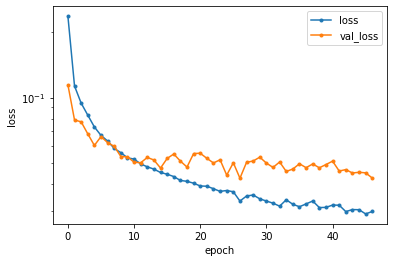

Confusion matrix, without normalization
[[18073    29    13     1     2]
 [  134   415     6     0     1]
 [   68     5  1353    18     4]
 [   46     0    17    99     0]
 [   26     0     3     0  1579]]


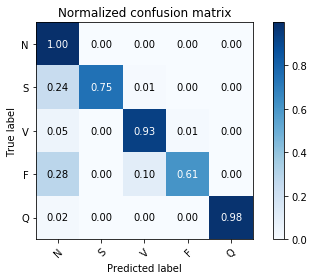

In [2]:
print(
    "Train accuracy:",
    model_res.evaluate(inputs["train"], labels["train"], verbose=0)[1],
)
print(
    "Test accuracy:",
    model_res.evaluate(inputs["test"], labels["test"], verbose=0)[1],
)
plot.plot_fit_history(history)

test_pred = np.argmax(model_res.predict(inputs["test"]), axis=1)
plot.plot_cm(sparse_labels["test"], test_pred, classes=np.array(["N", "S", "V", "F", "Q"]), normalize=True)